In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('../names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chrs)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

### (5/3) is the scaling factor

/ sqrt(n_embd * block_size) is the Xavier-like scaling

🔍 Why (5/3)?
This scaling appears to be based on Kaiming (He) initialization for use with tanh or leaky ReLU-like activations. In some custom designs, researchers use (5/3) specifically when using tanh activations to adjust for the fact that tanh squashes values.
It's likely meant to adjust for the nonlinear effects of tanh:
tanh reduces variance
Multiplying by (5/3) boosts variance to compensate

🔍 Why / sqrt(fan_in)?
This is variance normalization, so the variance of the output doesn't blow up with increasing input dimension. Standard in Xavier and Kaiming initializations.

🔹 Line 2: b1 — Bias vector
Keeps early activations centered around zero
Helps gradients flow better, especially with tanh or sigmoid

🔹 Line 3: W2 — Output layer weights
Small weights prevent large logits, which can hurt stability in cross-entropy
Often you don’t want big logits early in training

In [3]:
# Parameters
block_size = 3
batch_size = 32
n_embd = 10  # the dimensionality of the character embedding
n_hidden = 200

g  = torch.Generator().manual_seed(1337)
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3)/((n_embd * block_size) ** 0.5) #* 0.3
b1 = torch.randn((n_hidden),                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn((vocab_size),                      generator=g) * 0 #to stabilize the logits

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [13]:
# build the dataset

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.size(), Y.size())
    return X, Y

random.seed(1337)
random.shuffle(words)
n1 = int(len(words)* 0.8)
n2 = int(len(words)* 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182587, 3]) torch.Size([182587])
torch.Size([22780, 3]) torch.Size([22780])
torch.Size([22779, 3]) torch.Size([22779])


In [15]:
# Optimization
max_steps = 80000
lossi = []
for step in range(max_steps):

    # minibatch
    b_ix = torch.randint(0, Xtr.size(0), (batch_size,), generator=g)
    Xb, Yb = Xtr[b_ix], Ytr[b_ix]

    # forward pass
    emb= C[Xb]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1

    ## batchnorm
    bnmeani = hpreact.mean(0, keepdim=True)  # for perfomance evaluation
    bnstdi = hpreact.std(0, keepdim=True) # for perfomance evaluation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non linearlity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = 0.1 if step < 10000 else 0.01
    for p in parameters:
        if p.grad is not None:
            p.data += -lr * p.grad
    
    # track stats
    if step % 10000 == 0:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f} :lr={lr}")
    lossi.append(loss.log10().item())

      0/  80000: 2.3177 :lr=0.1
  10000/  80000: 2.0400 :lr=0.01
  20000/  80000: 2.1616 :lr=0.01
  30000/  80000: 2.2818 :lr=0.01
  40000/  80000: 2.1449 :lr=0.01
  50000/  80000: 1.9675 :lr=0.01
  60000/  80000: 2.0966 :lr=0.01
  70000/  80000: 2.2373 :lr=0.01


Text(0.5, 1.0, 'before activation function')

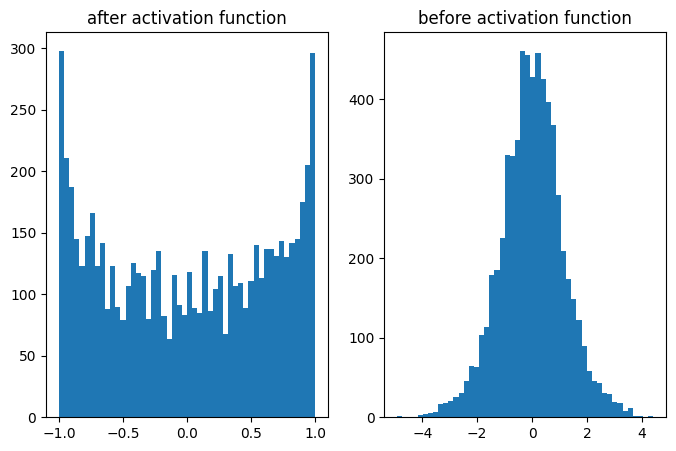

In [16]:
# after activation output
fig, axs = plt.subplots(1, 2, figsize=(8,5))  # 1 row, 2 columns
axs[0].hist(h.view(-1).tolist(),50);
axs[0].set_title("after activation function")
axs[1].hist(hpreact.view(-1).tolist(),50);
axs[1].set_title("before activation function")


Text(0.5, 1.0, 'lossi')

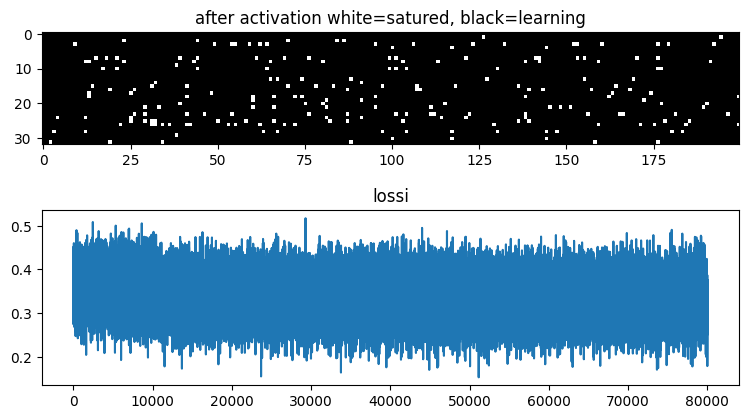

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(9,5))  # 1 row, 2 columns
axs[0].imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
axs[0].set_title("after activation white=satured, black=learning")
axs[1].plot(lossi)
axs[1].set_title("lossi")

In [18]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    # mearue the mean and stdev
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.139954090118408
val 2.1689810752868652


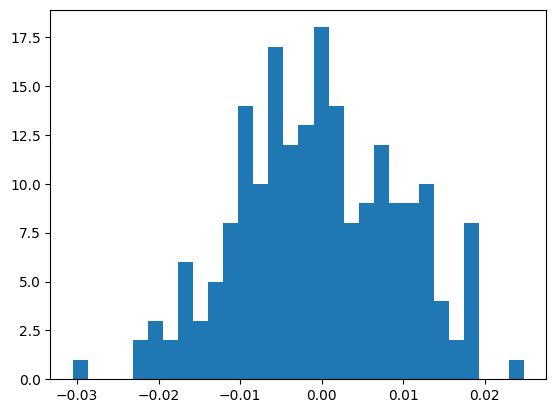

In [20]:
plt.hist(b1.view(-1).tolist(), 30);

In [23]:
@torch.no_grad()
def split_loss(split):

    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(-1, n_embd * block_size)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.140204668045044
val 2.1691184043884277


In [24]:
# generate sample

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, n_embd * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


rukshmichaven.
zellynn.
yovina.
tie.
nor.
tamirmanoelaniyanaziconncxeph.
sardelv.
jaya.
lyllagiidee.
lam.
gdremayajust.
kavickadaryshayda.
jaxen.
sanjace.
liyanalgoriyahhaevondlyn.
nikhammir.
kvingy.
damya.
carleemandstoshaidarivetzieidarctedvie.
krist.
